## Homework 3 (you need to complete this homework or Project).

#### Source with comments : http://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/
#### 1. Compare recommendations quality and inference time for ALS (Alternating Least Squares without biases) and SGD (Stochastic Gradient Descent without biases) using different regularization values (0.001, 0.01, ...) and factors (1, 10, 25, 50, ...). Improve the code to implement SGD.

#### 2. Change the ALS code so it can perform calculations with biases. Decent instructions can be found here: http://activisiongamescience.github.io/2016/01/11/Implicit-Recommender-Systems-Biased-Matrix-Factorization/.

#### 3. Compare all 4 approaches by MSE, training time, inference time. Put your results (in addition to ipython cells runs) in a summary table. Make qualitative conclusions.

#### 4. Make your own explanation why this ALS implementation does not work good w.r.t. MSE. Try to enhance it if possible or compare it with other implementation(s) (e.g., ALS from Apache Spark MLlib).

#### Data source: MovieLens 100k. You can choose another dataset, but it cannot have smaller number of ratings or users and items.

#### Send your reports to dmitrii.ignatov@gmail.com with obligatory CC to dvpozdnyakov@hse.ru. Topic:  [RecSys4DS2024-HW3]-<LastName_FirstName>

#### Soft Deadline: 7.12.2024

#### Hard Deadline: 9.12.2024


The model loss function:

$L = \sum\limits_{u,i}(r_{ui} - (\mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}))^{2}$+$\lambda_{xb} \sum\limits_{u} \left\Vert b_{u} \right\Vert^{2} + \lambda_{yb}\sum\limits_{i} \left\Vert b_{i} \right\Vert^{2}+
\lambda_{xf} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{yf} \sum\limits_{i} \left\Vert \textbf{y}_{i} \right\Vert^{2}$

In [6]:
import numpy as np
import pandas as pd
np.random.seed(0)

MovieLens dataset


### Load data and create ratings matrix $r_{ij}$

In [7]:
# Load dataset
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('/Users/ilyapchelintsev/Maga/RecSys/datasets/ml-100k/u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

# Create r_{ui}, our ratings matrix
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [8]:
print("Форма матрицы рейтингов:", ratings.shape)

# Выведем первые 5 строк и первые 5 столбцов матрицы
print("Пример первых 5x5 элементов матрицы рейтингов:")
print(ratings[:5, :5])

Форма матрицы рейтингов: (943, 1682)
Пример первых 5x5 элементов матрицы рейтингов:
[[5. 3. 4. 3. 3.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [4. 3. 0. 0. 0.]]


### Split test and train

In [9]:
# Split into training and test sets.
# Remove 10 ratings for each user and assign them to the test set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in np.arange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=10,
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test

### Metric

In [10]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

### Class implementing ALS and ExplicitMF with gradient descent and biases

In [11]:
from numpy.linalg import solve


class ExplicitMF():
    def __init__(self,
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0,
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty
        entries in a matrix. The terminology assumes a
        ratings matrix which is ~ user x item

        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings

        n_factors : (int)
            Number of latent factors to use in matrix
            factorization model
        learning : (str)
            Method of optimization. Options include
            'sgd' or 'als'.

        item_fact_reg : (float)
            Regularization term for item latent factors

        user_fact_reg : (float)
            Regularization term for user latent factors

        item_bias_reg : (float)
            Regularization term for item biases

        user_bias_reg : (float)
            Regularization term for user biases

        verbose : (bool)
            Whether or not to printout training progress
        """

        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI),
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda

            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI),
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))

        if self.learning == 'als':
            self.partial_train(n_iter,0)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter,0)


    def partial_train(self, n_iter, iter_done):
        """
        Train model for n_iter iterations. Can be
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if (ctr+iter_done) % 10 == 0 and self._v:
                print (f'\tcurrent iteration: {ctr+iter_done}')
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs,
                                               self.item_vecs,
                                               self.ratings,
                                               self.user_fact_reg,
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs,
                                               self.user_vecs,
                                               self.ratings,
                                               self.item_fact_reg,
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error

            # Update biases
            self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])

            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate *\
                                    (e * self.item_vecs[i, :] - self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction

    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)

        return predictions

    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.

        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).

        The function creates two new class attributes:

        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print (f'Iteration: {n_iter}')
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff, iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print (f'MSE train:test: {round(self.train_mse[-1],2)} : {round(self.test_mse[-1],2)}\n')
            iter_diff = n_iter

#### Plots

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=3)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=3)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Iterations', fontsize=25);
    plt.ylabel('MSE', fontsize=25);
    plt.legend(loc='best', fontsize=20);

##### Gradient descent with biases

In [13]:
train, test = train_test_split(ratings)
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

In [ ]:
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 1.14 : 1.19

Iteration: 2
MSE train:test: 1.07 : 1.14

Iteration: 5
MSE train:test: 0.98 : 1.06

Iteration: 10
	current iteration: 10
MSE train:test: 0.92 : 1.01

Iteration: 25
	current iteration: 20
MSE train:test: 0.87 : 0.96

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 0.84 : 0.94

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 0.75 : 0.92

Iteration: 200
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
MSE train:test: 0.4 : 0.92



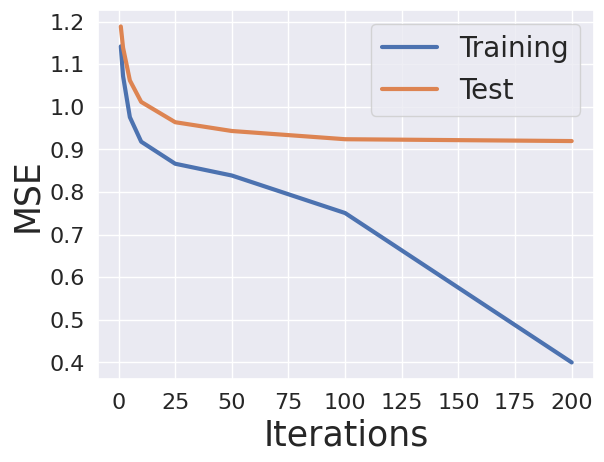

In [ ]:
plot_learning_curve(iter_array, MF_SGD)

#### ALS without biases

In [ ]:
MF_ALS = ExplicitMF(train, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_ALS.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 5.52 : 9.93

Iteration: 2
MSE train:test: 4.21 : 8.66

Iteration: 5
MSE train:test: 3.97 : 8.5

Iteration: 10
	current iteration: 10
MSE train:test: 3.93 : 8.48

Iteration: 25
	current iteration: 20
MSE train:test: 3.92 : 8.47

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 3.92 : 8.48

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 3.92 : 8.48

Iteration: 200
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
MSE train:test: 3.92 : 8.47



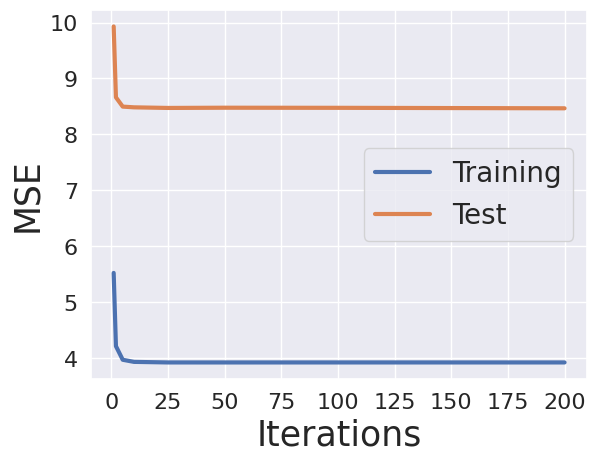

In [ ]:
plot_learning_curve(iter_array, MF_ALS)

# Homework

In [66]:
#imports
import time
import pandas as pd
from itertools import product
from tqdm import tqdm
import seaborn as sns
import numpy as np
from numpy.linalg import solve

## Task 1

In [67]:
lr = 0.0001
results = []

pbar = tqdm(product(['als', 'sgd'], [0.01, 0.1, 1.0], [1, 10, 25, 50]))
for method, reg, n_f in pbar:
            res = {'Method': method.upper(),
            'Regularization': reg,
            'Factors': n_f}
            pbar.set_description(f"Testing {method.upper()} with reg={reg}, n_factors={n_f}")
            model = ExplicitMF(train, n_factors=n_f, learning=method,
                               item_fact_reg=reg, user_fact_reg=reg)

            start_time = time.time()
            model.train(n_iter=10, learning_rate=lr if method == 'sgd' else None)
            res['Training Time'] = time.time() - start_time

            start_time = time.time()
            predictions = model.predict_all()
            res['Inference Time'] = time.time() - start_time

            res['Train MSE'] = get_mse(predictions, train)
            res['Test MSE'] = get_mse(predictions, test)

            results.append(res)

results_df = pd.DataFrame(results).sort_values(by='Test MSE')


Testing SGD with reg=1.0, n_factors=50: : 24it [02:19,  5.80s/it] 


In [68]:
results_df

,Method,Regularization,Factors,Training Time,Inference Time,Train MSE,Test MSE
18,SGD,0.10,25,6.604525,1.393317,1.141892,1.188347
15,SGD,0.01,50,6.527035,1.419919,1.141903,1.188351
19,SGD,0.10,50,6.614169,1.396018,1.141878,1.188411
14,SGD,0.01,25,6.461759,1.426258,1.141860,1.188485
23,SGD,1.00,50,6.554722,1.416713,1.141897,1.188503
21,SGD,1.00,10,6.544699,1.436381,1.142318,1.188509
22,SGD,1.00,25,6.567127,1.395567,1.141830,1.188639
17,SGD,0.10,10,6.501007,1.400092,1.142319,1.190344
13,SGD,0.01,10,6.459376,1.398281,1.142286,1.190767
20,SGD,1.00,1,7.362245,1.428498,1.529484,1.667366


## Task 2

In [69]:
class ExplicitMFWithBias():
    def __init__(self, ratings, n_factors=40, reg=0.1):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.reg = reg
        self.global_bias = np.mean(ratings[ratings > 0])
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_items)
        self.user_factors = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))

    def train(self, n_iter=10):
        for _ in range(n_iter):
            self.als_step()
            self.update_bias()

    def als_step(self):
        # user step
        VTV = self.item_factors.T @ self.item_factors
        VTV = VTV + np.eye(VTV.shape[0]) * self.reg
        for u in range(self.n_users):
            self.user_factors[u, :] = solve(VTV, (self.ratings[u, :] - self.global_bias - self.item_bias).dot(self.item_factors))
        # item step
        VTV = self.user_factors.T @ self.user_factors
        VTV = VTV + np.eye(VTV.shape[0]) * self.reg
        for i in range(self.n_items):
            self.item_factors[i, :] = solve(VTV, (self.ratings[:, i] - self.global_bias - self.user_bias).T.dot(self.user_factors))


    def update_bias(self):
        # user bias
        for u in range(self.n_users):
            n = np.sum(self.ratings[u, :] - self.global_bias - self.item_bias - self.user_factors[u, :] @ self.item_factors.T)
            d =  np.sum(self.ratings[u, :] > 0) + self.reg
            self.user_bias[u] = np.clip(n / d, -10, 10)
        # item bias
        for i in range(self.n_items):
            n = np.sum(self.ratings[:, i] - self.global_bias - self.user_bias - self.user_factors @ self.item_factors[i, :].T)
            d = np.sum(self.ratings[:, i] > 0) + self.reg
            self.item_bias[i] = np.clip(n / d, -10, 10)

    def predict_all(self):
        return self.global_bias + self.user_bias[:, np.newaxis] + self.item_bias[np.newaxis, :] + self.user_factors @ self.item_factors.T


In [ ]:
class ExplicitMFWithBiasSGD():
    def __init__(self, ratings, n_factors=40, reg=0.1, learning_rate=0.01):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.reg = reg
        self.learning_rate = learning_rate

        self.global_bias = np.mean(ratings[ratings > 0])
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_items)

        self.user_factors = np.random.normal(scale=1.0/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=1.0/self.n_factors, size=(self.n_items, self.n_factors))

    def train(self, n_iter=10):
        known_ratings = np.array(np.nonzero(self.ratings)).T

        for _ in range(n_iter):
            np.random.shuffle(known_ratings)
            for u, i in known_ratings:
                error = self.ratings[u, i] - self.predict_single(u, i)

                self.user_bias[u] += self.learning_rate * (error - self.reg * self.user_bias[u])
                self.item_bias[i] += self.learning_rate * (error - self.reg * self.item_bias[i])

                user_factors_old = self.user_factors[u, :].copy()
                self.user_factors[u, :] += self.learning_rate * (error * self.item_factors[i, :] - self.reg * self.user_factors[u, :])
                self.item_factors[i, :] += self.learning_rate * (error * user_factors_old - self.reg * self.item_factors[i, :])

    def predict_single(self, u, i):
        return (
            self.global_bias +
            self.user_bias[u] +
            self.item_bias[i] +
            self.user_factors[u, :] @ self.item_factors[i, :].T
        )

    def predict_all(self):
        return (
            self.global_bias +
            self.user_bias[:, np.newaxis] +
            self.item_bias[np.newaxis, :] +
            self.user_factors @ self.item_factors.T
        )


In [71]:
lr = 0.01
results_bias = []

pbar = tqdm(product(['als_b', 'sgd_b'], [0.01, 0.1, 1.0], [1, 10, 25, 50]))
for method, reg, n_factors in pbar:
        res = {'Method': method.upper(),
            'Regularization': reg,
            'Factors': n_factors}
        pbar.set_description(f"Testing {method.upper()} with reg={reg}, n_factors={n_factors}")

        if method == 'als_b':
            model = ExplicitMFWithBias(train, n_factors=n_factors, reg=reg)
        elif method == 'sgd_b':
            model = ExplicitMFWithBiasSGD(train, n_factors=n_factors, reg=reg, learning_rate=lr)

        start_time = time.time()
        model.train(n_iter=10)
        res['Training Time'] = time.time() - start_time

        start_time = time.time()
        predictions = model.predict_all()
        res['Inference Time'] = time.time() - start_time

        res['Train MSE'] = get_mse(predictions, train)
        res['Test MSE'] = get_mse(predictions, test)

        results_bias.append(res)

results_bias_df = pd.DataFrame(results_bias).sort_values(by='Test MSE')

Testing SGD_B with reg=1.0, n_factors=50: : 24it [02:09,  5.41s/it] 


In [72]:
results_bias_df

,Method,Regularization,Factors,Training Time,Inference Time,Train MSE,Test MSE
14,SGD_B,0.01,25,7.610999,0.004227,0.766690,0.925835
15,SGD_B,0.01,50,7.892108,0.005495,0.788540,0.926501
13,SGD_B,0.01,10,7.287658,0.005009,0.741844,0.926910
17,SGD_B,0.10,10,7.482235,0.004858,0.829076,0.936068
18,SGD_B,0.10,25,7.509393,0.003972,0.837447,0.938023
19,SGD_B,0.10,50,7.500017,0.004507,0.839514,0.938292
16,SGD_B,0.10,1,8.371043,0.003998,0.835381,0.964375
12,SGD_B,0.01,1,8.294980,0.004197,0.827711,0.971843
22,SGD_B,1.00,25,7.686250,0.008006,0.944043,1.005382
20,SGD_B,1.00,1,8.197253,0.004367,0.944028,1.005548


In [73]:
results_df['Bias'] = False
results_bias_df['Bias'] = True

combined_results = pd.concat([results_df, results_bias_df], ignore_index=True)
combined_results = combined_results.sort_values(by=['Bias', 'Test MSE']).reset_index(drop=True)
combined_results = combined_results.round({
    'Train MSE': 4,
    'Test MSE': 4,
    'Training Time': 4,
    'Inference Time': 4
})
combined_results


,Method,Regularization,Factors,Training Time,Inference Time,Train MSE,Test MSE,Bias
0,SGD,0.10,25,6.6045,1.3933,1.1419,1.1883,False
1,SGD,0.01,50,6.5270,1.4199,1.1419,1.1884,False
2,SGD,0.10,50,6.6142,1.3960,1.1419,1.1884,False
3,SGD,0.01,25,6.4618,1.4263,1.1419,1.1885,False
4,SGD,1.00,50,6.5547,1.4167,1.1419,1.1885,False
5,SGD,1.00,10,6.5447,1.4364,1.1423,1.1885,False
6,SGD,1.00,25,6.5671,1.3956,1.1418,1.1886,False
7,SGD,0.10,10,6.5010,1.4001,1.1423,1.1903,False
8,SGD,0.01,10,6.4594,1.3983,1.1423,1.1908,False
9,SGD,1.00,1,7.3622,1.4285,1.5295,1.6674,False


## Task 3

In [74]:
combined_results.to_csv('results.csv', index=False)

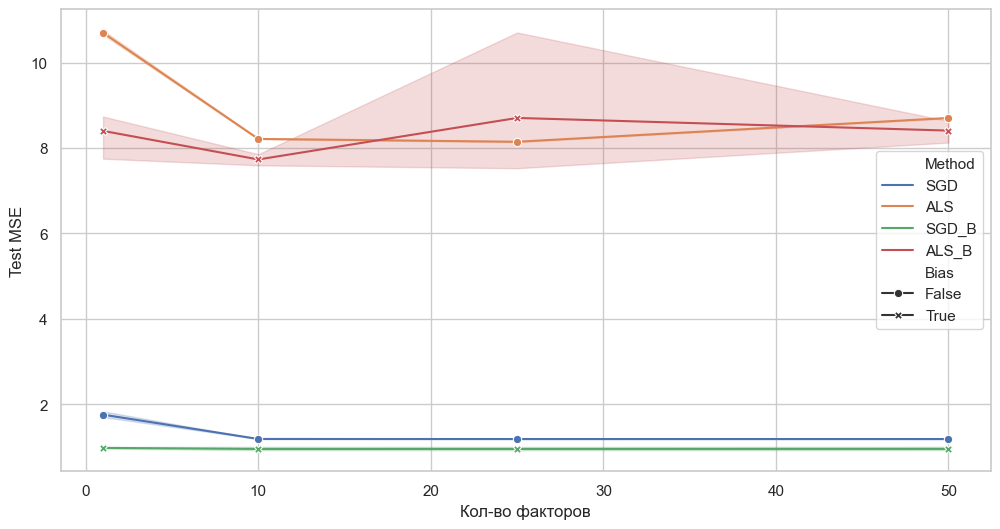

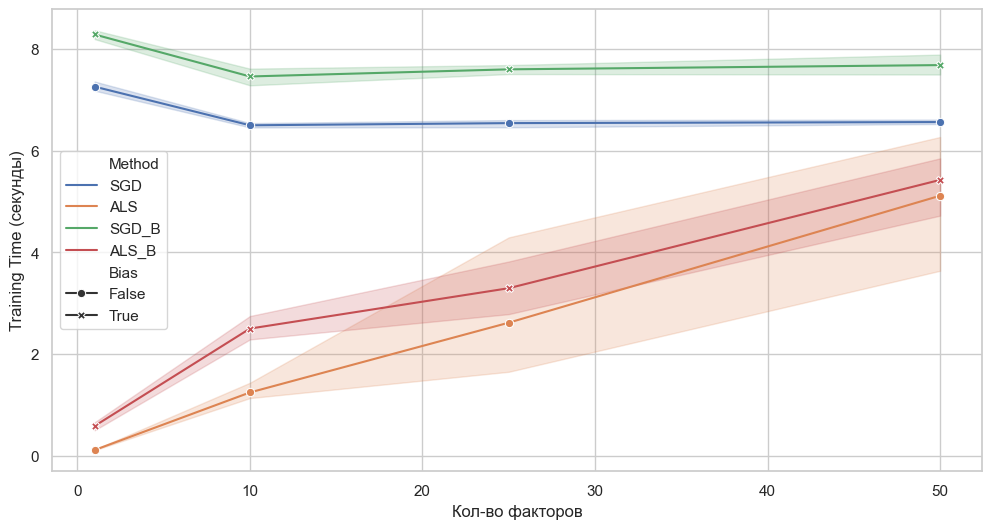

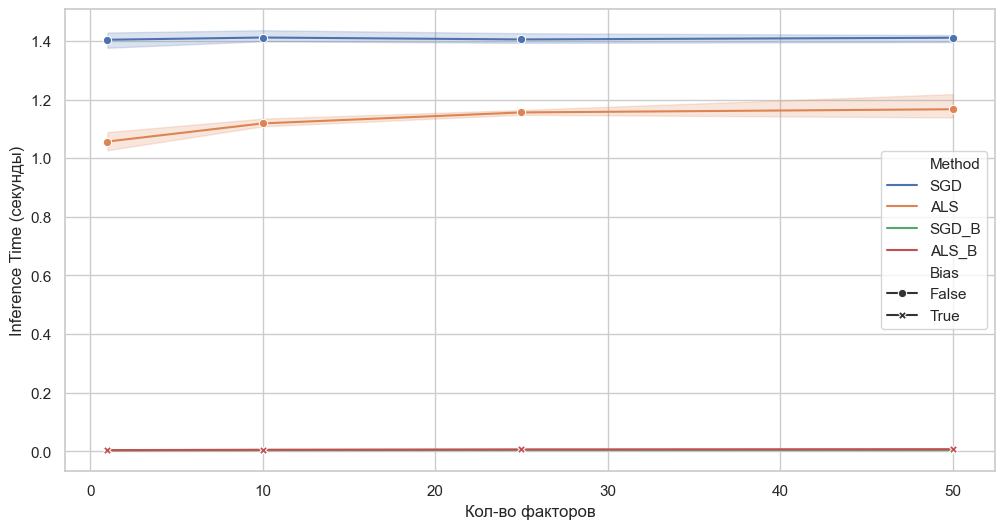

In [75]:
metrics = ["Test MSE", "Training Time", "Inference Time"]
labels = ["Test MSE", "Training Time (секунды)","Inference Time (секунды)"]    

for m, l in zip(metrics, labels):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=combined_results,
        x="Factors",
        y=m,
        hue="Method",
        style="Bias",
        markers=True,
        dashes=False,
    )
    plt.xlabel("Кол-во факторов")
    plt.ylabel(l)
    plt.legend()
    plt.grid(True)
    plt.show()

    1) Модель ALS со смещениями показала себя наихудшим образов с точки зрения предсказания - её ошибка хуже остальных подходов почти во всех количествах факторов кроме 10, где качество равно обычной ALS-модели
    2) По операционной скорости модель ALS_B вторая, обгоняя SGD по времени тренировки а без смешенные методы - по периоду предсказания.

## Task 4 

Текущая реализация метода альтернативных наименьших квадратов (ALS) демонстрирует недостаточную эффективность в решении задач рекомендательных систем по нескольким причинам. 

    1) Набор данных MovieLens 100k является разреженным, что затрудняет алгоритму выявление взаимосвязей из-за большого количества пропусков. 
    2) Модель не учитывает смещения, такие как популярность фильмов или привычки пользователей к выставлению высоких или низких оценок, что могло бы существенно снизить уровень ошибки предсказаний. 
    3) Выбор гиперпараметров: неправильная настройка регуляризации или числа факторов может привести к недообучению или переобучению модели. Кроме того, сам алгоритм ALS оптимизирует параметры для всех пользователей и фильмов одновременно, что делает его менее адаптивным по сравнению с другими методами, такими как стохастический градиентный спуск (SGD).

Для повышения эффективности алгоритма рекомендуется: 

    1) Оптимальный подбор гиперпараметров с использованием методов кросс-валидации
    2) Определение априорной оценки смещение, например, средние оценки, популярность фильма или жанра, для пользователей может быть полезно применять усреднение по региону
    Дополнительно можно рассмотреть использование более оптимизированных реализаций ALS, таких как те, что представлены в Apache Spark MLlib, которые лучше подходят для работы с разреженными данными.